In [1]:
import matplotlib.pyplot as plt
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation,Convolution2D,MaxPooling2D,Flatten,BatchNormalization,Dropout
from tensorflow.python.client import device_lib
from sklearn.preprocessing import StandardScaler
%matplotlib inline

C:\Anaconda\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


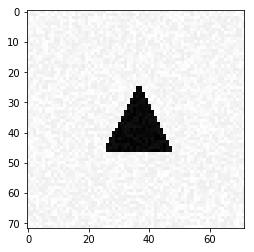

In [2]:
# On some implementations of matplotlib, you may need to change this value
IMAGE_SIZE = 72

def generate_a_drawing(figsize, U, V, noise=0.0):
    fig = plt.figure(figsize=(figsize,figsize))
    ax = plt.subplot(111)
    plt.axis('Off')
    ax.set_xlim(0,figsize)
    ax.set_ylim(0,figsize)
    ax.fill(U, V, "k")
    fig.canvas.draw()
    imdata = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)[::3].astype(np.float32)
    imdata = imdata + noise * np.random.random(imdata.size)
    plt.close(fig)
    return imdata

def generate_a_rectangle(noise=0.0, free_location=False):
    figsize = 1.0    
    U = np.zeros(4)
    V = np.zeros(4)
    if free_location:
        corners = np.random.random(4)
        top = max(corners[0], corners[1])
        bottom = min(corners[0], corners[1])
        left = min(corners[2], corners[3])
        right = max(corners[2], corners[3])
    else:
        side = (0.3 + 0.7 * np.random.random()) * figsize
        top = figsize/2 + side/2
        bottom = figsize/2 - side/2
        left = bottom
        right = top
    U[0] = U[1] = top
    U[2] = U[3] = bottom
    V[0] = V[3] = left
    V[1] = V[2] = right
    return generate_a_drawing(figsize, U, V, noise)


def generate_a_disk(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        center = np.random.random(2)
    else:
        center = (figsize/2, figsize/2)
    radius = (0.3 + 0.7 * np.random.random()) * figsize/2
    N = 50
    U = np.zeros(N)
    V = np.zeros(N)
    i = 0
    for t in np.linspace(0, 2*np.pi, N):
        U[i] = center[0] + np.cos(t) * radius
        V[i] = center[1] + np.sin(t) * radius
        i = i + 1
    return generate_a_drawing(figsize, U, V, noise)

def generate_a_triangle(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        U = np.random.random(3)
        V = np.random.random(3)
    else:
        size = (0.3 + 0.7 * np.random.random())*figsize/2
        middle = figsize/2
        U = (middle, middle+size, middle-size)
        V = (middle+size, middle-size, middle-size)
    imdata = generate_a_drawing(figsize, U, V, noise)
    return [imdata, [U[0], V[0], U[1], V[1], U[2], V[2]]]


im = generate_a_rectangle(10, True)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

im = generate_a_disk(10)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

[im, v] = generate_a_triangle(20, False)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')


def generate_dataset_classification(nb_samples, noise=0.0, free_location=False):
    # Getting im_size:
    im_size = generate_a_rectangle().shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros(nb_samples)
    print('Creating data:')
    for i in range(nb_samples):
        if i % 10 == 0:
            print(i)
        category = np.random.randint(3)
        if category == 0:
            X[i] = generate_a_rectangle(noise, free_location)
        elif category == 1: 
            X[i] = generate_a_disk(noise, free_location)
        else:
            [X[i], V] = generate_a_triangle(noise, free_location)
        Y[i] = category
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

def generate_test_set_classification():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_classification(300, 20, True)
    Y_test = keras.utils.to_categorical(Y_test, 3) 
    return [X_test, Y_test]

def generate_dataset_regression(nb_samples, noise=0.0):
    # Getting im_size:
    im_size = generate_a_triangle()[0].shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros([nb_samples, 6])
    print('Creating data:')
    for i in range(nb_samples):
        if i % 10 == 0:
            print(i)
        [X[i], Y[i]] = generate_a_triangle(noise, True)
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

import matplotlib.patches as patches

def visualize_prediction(x, y):
    fig, ax = plt.subplots(figsize=(5, 5))
    I = x.reshape((IMAGE_SIZE,IMAGE_SIZE))
    ax.imshow(I, extent=[-0.15,1.15,-0.15,1.15],cmap='gray')
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])

    xy = y.reshape(3,2)
    tri = patches.Polygon(xy, closed=True, fill = False, edgecolor = 'r', linewidth = 5, alpha = 0.5)
    ax.add_patch(tri)

    plt.show()

def generate_test_set_regression():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_regression(300, 20)
    return [X_test, Y_test]



## 3 Simple classification

In [3]:
#create the datasets
[X_train, Y_train] = generate_dataset_classification(300, 20)
[X_test, Y_test] = generate_test_set_classification()

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


In [4]:
Y_train_categorical = keras.utils.to_categorical(Y_train)

nb_of_classes = 3

#Create linear model
model =Sequential()

model.add(Dense(nb_of_classes,input_shape=(X_train.shape[1],),activation = 'softmax'))

#Compile the model 
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam',metrics=['acc']) 

#Fit the model
history= model.fit(X_train,Y_train_categorical,validation_data=(X_test,Y_test),epochs=50,batch_size=32,verbose=1)

Train on 300 samples, validate on 300 samples
Epoch 1/50
300/300 [==============================] - 2s 8ms/step - loss: 1.3701 - acc: 0.4333 - val_loss: 1.3839 - val_acc: 0.2033
Epoch 2/50
300/300 [==============================] - 0s 375us/step - loss: 0.7440 - acc: 0.6700 - val_loss: 1.5721 - val_acc: 0.2667
Epoch 3/50
300/300 [==============================] - 0s 352us/step - loss: 0.5676 - acc: 0.7267 - val_loss: 1.6305 - val_acc: 0.2933
Epoch 4/50
300/300 [==============================] - 0s 401us/step - loss: 0.3709 - acc: 0.8700 - val_loss: 1.9145 - val_acc: 0.3033
Epoch 5/50
300/300 [==============================] - 0s 366us/step - loss: 0.3307 - acc: 0.8500 - val_loss: 2.1930 - val_acc: 0.2533
Epoch 6/50
300/300 [==============================] - 0s 366us/step - loss: 0.3198 - acc: 0.8467 - val_loss: 2.1445 - val_acc: 0.3367
Epoch 7/50
300/300 [==============================] - 0s 352us/step - loss: 0.2451 - acc: 0.9467 - val_loss: 2.3282 - val_acc: 0.3500
Epoch 8/50
300/300

## 4 Visualization of the Solution

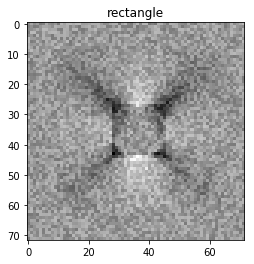

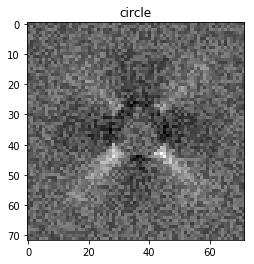

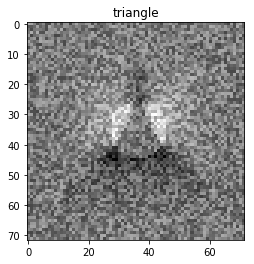

In [5]:
W,b = model.get_weights()
plt.figure(1)
plt.imshow(W[:,0].reshape(72,72), cmap='gray')
plt.title('rectangle')

plt.figure(2)
plt.imshow(W[:,1].reshape(72,72), cmap='gray')
plt.title('circle')

plt.figure(3)
plt.imshow(W[:,2].reshape(72,72), cmap='gray')
plt.title('triangle')

## A More Difficult Classification Problem

In [6]:
# create the datasets
[X_train, Y_train] = generate_dataset_classification(2000, 20, True)
[X_test, Y_test] = generate_test_set_classification()

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
1760
1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220


In [7]:
Y_train_categorical = keras.utils.to_categorical(Y_train)

#Create linear model
model =Sequential()

model.add(Dense(nb_of_classes,input_shape=(X_train.shape[1],),activation = 'softmax'))

#Compile the model 
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam',metrics=['acc']) 

#Fit the model
history= model.fit(X_train,Y_train_categorical,validation_data=(X_test,Y_test),epochs=100,batch_size=32,verbose=1)
print('linear classifier score: ',model.evaluate(X_test, Y_test))

Train on 2000 samples, validate on 300 samples
Epoch 1/100
2000/2000 [==============================] - 1s 504us/step - loss: 1.4746 - acc: 0.4180 - val_loss: 1.1424 - val_acc: 0.4900
Epoch 2/100
2000/2000 [==============================] - 1s 253us/step - loss: 0.9545 - acc: 0.5360 - val_loss: 0.8366 - val_acc: 0.5833
Epoch 3/100
2000/2000 [==============================] - 1s 289us/step - loss: 0.9193 - acc: 0.5465 - val_loss: 0.8185 - val_acc: 0.5633
Epoch 4/100
2000/2000 [==============================] - 1s 273us/step - loss: 0.9198 - acc: 0.5650 - val_loss: 0.8557 - val_acc: 0.5967
Epoch 5/100
2000/2000 [==============================] - 1s 277us/step - loss: 0.9589 - acc: 0.5480 - val_loss: 0.8681 - val_acc: 0.5800
Epoch 6/100
2000/2000 [==============================] - 0s 244us/step - loss: 0.8139 - acc: 0.6145 - val_loss: 0.7859 - val_acc: 0.6267
Epoch 7/100
2000/2000 [==============================] - 1s 263us/step - loss: 0.8075 - acc: 0.5925 - val_loss: 1.1039 - val_acc: 0

2000/2000 [==============================] - 1s 265us/step - loss: 0.6321 - acc: 0.7095 - val_loss: 0.8325 - val_acc: 0.6267
Epoch 61/100
2000/2000 [==============================] - 1s 252us/step - loss: 0.6326 - acc: 0.7090 - val_loss: 0.8033 - val_acc: 0.6200
Epoch 62/100
2000/2000 [==============================] - 1s 252us/step - loss: 0.6742 - acc: 0.6790 - val_loss: 0.7436 - val_acc: 0.6267
Epoch 63/100
2000/2000 [==============================] - 0s 243us/step - loss: 0.6745 - acc: 0.6845 - val_loss: 0.9496 - val_acc: 0.5967
Epoch 64/100
2000/2000 [==============================] - 1s 252us/step - loss: 0.8164 - acc: 0.6380 - val_loss: 0.7738 - val_acc: 0.6500
Epoch 65/100
2000/2000 [==============================] - 1s 250us/step - loss: 0.6773 - acc: 0.6940 - val_loss: 0.7853 - val_acc: 0.6433
Epoch 66/100
2000/2000 [==============================] - 0s 250us/step - loss: 0.6541 - acc: 0.7040 - val_loss: 0.8071 - val_acc: 0.6433
Epoch 67/100
2000/2000 [=======================

In [8]:
X_train = X_train.reshape((-1,72,72,1))
X_test = X_test.reshape((-1,72,72,1))
#conv net
model =Sequential()

model.add(Convolution2D(16,kernel_size=(5,5),input_shape=(72,72,1,)))
model.add(MaxPooling2D(pool_size=(3,3)))
model.add(Flatten())
model.add(Dense(nb_of_classes,activation = 'softmax'))

model.compile(loss = 'categorical_crossentropy', optimizer = 'adam',metrics=['acc']) 

history= model.fit(X_train,Y_train_categorical,validation_data=(X_test,Y_test),epochs=100,batch_size=32)

print('conv net score: ',model.evaluate(X_test, Y_test))

Train on 2000 samples, validate on 300 samples
Epoch 1/100
2000/2000 [==============================] - 2s 919us/step - loss: 0.9216 - acc: 0.5925 - val_loss: 0.8192 - val_acc: 0.6200
Epoch 2/100
2000/2000 [==============================] - 1s 404us/step - loss: 0.7008 - acc: 0.7140 - val_loss: 0.6271 - val_acc: 0.7833
Epoch 3/100
2000/2000 [==============================] - 1s 397us/step - loss: 0.5969 - acc: 0.7760 - val_loss: 0.6003 - val_acc: 0.8167
Epoch 4/100
2000/2000 [==============================] - 1s 390us/step - loss: 0.5530 - acc: 0.7815 - val_loss: 0.5263 - val_acc: 0.8067
Epoch 5/100
2000/2000 [==============================] - 1s 399us/step - loss: 0.4784 - acc: 0.8420 - val_loss: 0.5297 - val_acc: 0.7767
Epoch 6/100
2000/2000 [==============================] - 1s 406us/step - loss: 0.4617 - acc: 0.8330 - val_loss: 0.4707 - val_acc: 0.8333
Epoch 7/100
2000/2000 [==============================] - 1s 391us/step - loss: 0.4097 - acc: 0.8635 - val_loss: 0.4428 - val_acc: 0

2000/2000 [==============================] - 1s 397us/step - loss: 0.0114 - acc: 1.0000 - val_loss: 0.2341 - val_acc: 0.9233
Epoch 61/100
2000/2000 [==============================] - 1s 399us/step - loss: 0.0117 - acc: 1.0000 - val_loss: 0.2406 - val_acc: 0.9233
Epoch 62/100
2000/2000 [==============================] - 1s 394us/step - loss: 0.0111 - acc: 0.9995 - val_loss: 0.2350 - val_acc: 0.9200
Epoch 63/100
2000/2000 [==============================] - 1s 415us/step - loss: 0.0101 - acc: 1.0000 - val_loss: 0.2581 - val_acc: 0.9267
Epoch 64/100
2000/2000 [==============================] - 1s 426us/step - loss: 0.0095 - acc: 1.0000 - val_loss: 0.2415 - val_acc: 0.9267
Epoch 65/100
2000/2000 [==============================] - 1s 434us/step - loss: 0.0089 - acc: 1.0000 - val_loss: 0.2500 - val_acc: 0.9200
Epoch 66/100
2000/2000 [==============================] - 1s 374us/step - loss: 0.0078 - acc: 1.0000 - val_loss: 0.2596 - val_acc: 0.9233
Epoch 67/100
2000/2000 [=======================

## 6 A Regression Problem

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


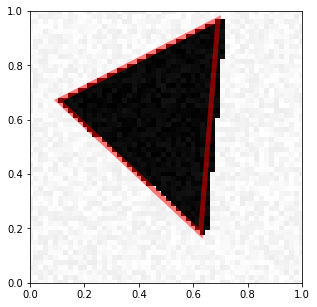

In [11]:
#Create the datasets
[X_train, Y_train] = generate_dataset_regression(1000, 20)
[X_test, Y_test] = generate_test_set_regression()

#Normalize the data
normalizer = StandardScaler()
y_train_normalize = normalizer.fit_transform(Y_train)
y_test_normalize = normalizer.transform(Y_test)

nb_of_features_output = 6
visualize_prediction(X_train[0], Y_train[0])

Train on 1000 samples, validate on 300 samples
Epoch 1/50
1000/1000 [==============================] - 1s 738us/step - loss: 2.2781 - val_loss: 1.0635
Epoch 2/50
1000/1000 [==============================] - 0s 223us/step - loss: 1.0040 - val_loss: 0.9153
Epoch 3/50
1000/1000 [==============================] - 0s 221us/step - loss: 0.9817 - val_loss: 0.9481
Epoch 4/50
1000/1000 [==============================] - 0s 214us/step - loss: 0.9229 - val_loss: 0.9069
Epoch 5/50
1000/1000 [==============================] - 0s 244us/step - loss: 0.9939 - val_loss: 0.8886
Epoch 6/50
1000/1000 [==============================] - 0s 239us/step - loss: 0.9152 - val_loss: 1.0114
Epoch 7/50
1000/1000 [==============================] - 0s 207us/step - loss: 0.9473 - val_loss: 1.0155
Epoch 8/50
1000/1000 [==============================] - 0s 256us/step - loss: 1.0333 - val_loss: 1.2342
Epoch 9/50
1000/1000 [==============================] - 0s 239us/step - loss: 0.9923 - val_loss: 0.8433
Epoch 10/50
1000/

Epoch 28/50
1000/1000 [==============================] - 2s 2ms/step - loss: 0.3244 - val_loss: 0.9392
Epoch 29/50
1000/1000 [==============================] - 2s 2ms/step - loss: 0.3086 - val_loss: 0.9358
Epoch 30/50
1000/1000 [==============================] - 2s 2ms/step - loss: 0.3028 - val_loss: 0.9699
Epoch 31/50
1000/1000 [==============================] - 2s 2ms/step - loss: 0.2806 - val_loss: 0.9820
Epoch 32/50
1000/1000 [==============================] - 2s 2ms/step - loss: 0.2612 - val_loss: 0.9751
Epoch 33/50
1000/1000 [==============================] - 2s 2ms/step - loss: 0.2450 - val_loss: 0.9734
Epoch 34/50
1000/1000 [==============================] - 2s 2ms/step - loss: 0.2339 - val_loss: 0.9740
Epoch 35/50
1000/1000 [==============================] - 2s 2ms/step - loss: 0.2330 - val_loss: 0.9793
Epoch 36/50
1000/1000 [==============================] - 2s 2ms/step - loss: 0.2242 - val_loss: 0.9790
Epoch 37/50
1000/1000 [==============================] - 2s 2ms/step - lo

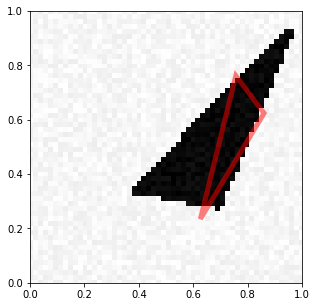

300/300 [==============================] - 0s 648us/step
neural network score:  0.9718744293848673


In [12]:
#A basic linear regressor model
model =Sequential()
model.add(Dense(nb_of_features_output,input_shape=(X_train.shape[1],)))

#Compile the model 
model.compile(loss='mean_squared_error',
              optimizer='adam')

history= model.fit(X_train,y_train_normalize,validation_data=(X_test,y_test_normalize),epochs=50,batch_size=32)
print('linear regressor score: ',model.evaluate(X_test, y_test_normalize))

#A Deep Neural Network with the sequential model

X_train = X_train.reshape((-1,72,72,1))
X_test = X_test.reshape((-1,72,72,1))

model =Sequential()

model.add(Convolution2D(40,kernel_size=(5,5),input_shape=(72,72,1,),activation='relu'))
model.add(Dropout(0.3))
model.add(Convolution2D(20,kernel_size=(4,4),activation='relu'))
model.add(Flatten())
model.add(Dropout(0.3))
model.add(Dense(nb_of_features_output))

#Compile the model 
model.compile(loss='mean_squared_error',
              optimizer='adam')

history= model.fit(X_train,y_train_normalize,validation_data=(X_test,y_test_normalize),epochs=50,batch_size=32)

predictions_test = model.predict(X_test)

Y_pred = normalizer.inverse_transform(predictions_test)
visualize_prediction(X_test[0], Y_pred[0])

print('neural network score: ',model.evaluate(X_test, y_test_normalize))

## 7 Image denoising